# 0. Video started at 04:17

In [1]:
import torch

from sklearn.model_selection import train_test_split
from torch import nn
from matplotlib import pyplot as plt

# 1. Data preparation

In [2]:
# create *known* parameters 
weight = 0.7
bias = 0.3

#create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

## 1.1 Train test split

In [3]:
shape_condition_false = X.shape != y.shape
if shape_condition_false:
    raise ValueError(f"Expected X and y to have same shape, got {X.shape} and {y.shape}")

#train test
train_split = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_split

print(
        f"X_train shape: {X_train.shape}", f"X_test shape: {X_test.shape}",
        f"y_train shape: {y_train.shape}", f"y_test shape: {y_test.shape}",
        sep="\n"
        )

X_train shape: torch.Size([40, 1])
X_test shape: torch.Size([10, 1])
y_train shape: torch.Size([40, 1])
y_test shape: torch.Size([10, 1])


## 1.2 Plot test | train data

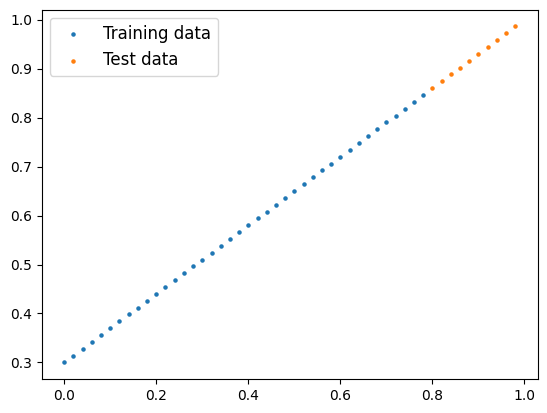

In [17]:
def plot_predictions(
        train_data=X_train,
        train_labels=y_train,
        test_data=X_test,
        test_labels=y_test,
        predictions=None
        ) -> None:

    dot_size = 5

    plt.scatter(train_data, train_labels, label='Training data', s=dot_size)
    plt.scatter(test_data, test_labels, label='Test data', s=dot_size)

    if predictions is not None:
        plt.scatter(test_data, predictions, label='Predictions', s=dot_size)
    plt.legend(loc='best', prop={"size": 12})


plot_predictions()

# 2. Build model 

In [5]:
from torch import nn


class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

model = LinearRegressionModel()
print(model.state_dict(), sep="\n")

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


## 2.1 Make predicitions with random intialised parameters just as an example 

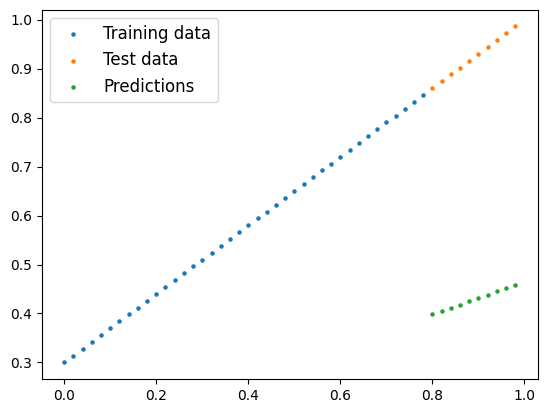

In [6]:
with torch.inference_mode():
    y_predictions = model(X_test)

plot_predictions(predictions=y_predictions)

## 2.2 Training loop

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
Epoch: 1990 | Loss: 0.0004444979131221771 | Test loss: 0.0005780101055279374
 OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])


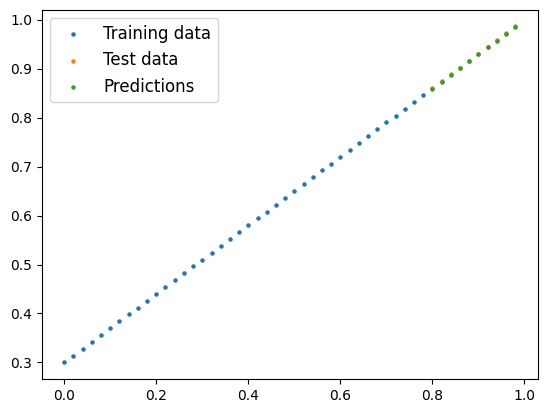

In [72]:
torch.manual_seed(RANDOM_SEED)
model = LinearRegressionModel()
print(model.state_dict())

loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

epochs = 2000

epoch_count: list[int] = []
loss_values: list[float] = []
test_loss_values: list[float] = []

for epoch in range(epochs):
    model.train()

    y_predictions = model(X_train)
    loss = loss_function(y_predictions, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.inference_mode():
        test_predictions = model(X_test)
        test_loss = loss_function(test_predictions, y_test)

    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}", end="\r")

with torch.inference_mode():
    print('\n', model.state_dict())
    pr = model(X_test)
    plot_predictions(predictions=pr)

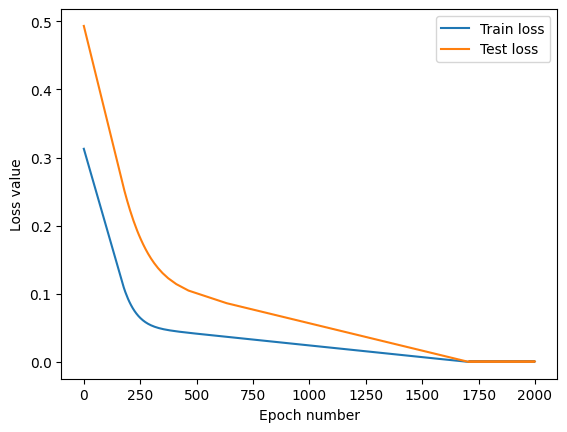

In [80]:
with torch.inference_mode():
    plt.plot(epoch_count, loss_values, label='Train loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.legend()
    plt.xlabel('Epoch number')
    plt.ylabel('Loss value')

# 3. Save | load model

## 3.1 Save model

In [85]:
from pathlib import Path

folder_path_to_save: str = "/Users/minkota/Documents/code/pytorch-deep-learning/experiments_data /01_experiments"
folder_path_to_save: Path = Path(folder_path_to_save)

model_save_path: Path = folder_path_to_save / "linear_regression_model.pth"

# torch.save(obj=model.state_dict(), f=model_save_path)

## 3.2 Load model

In [93]:
torch.manual_seed(RANDOM_SEED)

loaded_model = LinearRegressionModel()
print(loaded_model.state_dict())

loaded_model.load_state_dict(torch.load(model_save_path))
print(loaded_model.state_dict())

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])


In [111]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_predictions = loaded_model(X_test)
    model_predictions = model(X_test)

res = loaded_model_predictions == model_predictions

true_condition = res.unique()
if not true_condition:
    raise ValueError("Something went wrong when saving and loading the model")

# 4. Agnostic style code

In [4]:
import torch

from torch import nn
from time import sleep
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

OrderedDict([('linear_layer.weight', tensor([[0.6968]])), ('linear_layer.bias', tensor([0.3025]))])


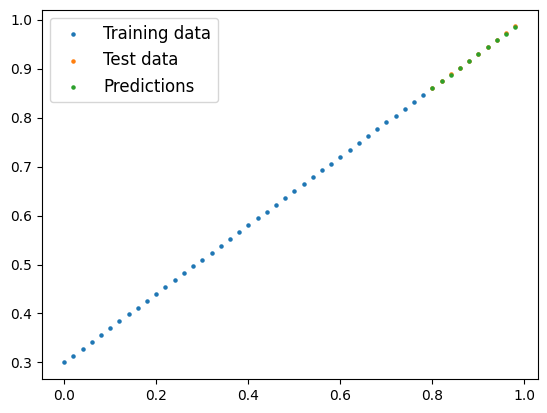

In [23]:
RANDOM_SEED = 42

# create *known* parameters 
weight = 0.7
bias = 0.3

#create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

shape_condition_false = X.shape != y.shape
if shape_condition_false:
    raise ValueError(f"Expected X and y to have same shape, got {X.shape} and {y.shape}")

# split data
train_split = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_split

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# model build
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


# model initialisation
torch.manual_seed(RANDOM_SEED)
model_1 = LinearRegressionModelV2()
model_1 = model_1.to(device=device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)
epochs = 200

# training loop
for epoch in range(epochs):
    model_1.train()
    
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        test_predictions = model_1(X_test)
        test_loss = loss_fn(test_predictions, y_test)
    
    if epochs % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}", end="\r")

model_1.eval()
print(model_1.state_dict())

with torch.inference_mode():
    plot_predictions(predictions=model_1(X_test))

# Video ended at 08:30